# 3D Convolutions for track finding

In this notebook we try 3D convolution instead of LSTM for classifying pixels, etc.

The detector is, as before, composed of square 2D layers.
I generate straight tracks that pass through every layer and leave hits deterministically.

In [1]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import keras.backend as K
from keras.regularizers import l2

# Local imports
from metrics import calc_hit_accuracy
from toydata import generate_data, track_hit_coords
from drawing import draw_layers, draw_projections, draw_train_history

# Magic
%matplotlib notebook

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 4007)


In [2]:
# Set random seed
np.random.seed(2017)

## Data generation

In [3]:
# Configuration
num_event = 102400
num_det_layers = 10
det_layer_size = 32
num_seed_layers = 3
avg_bkg_tracks = 3
noise_prob = 0.01
shape = (num_event, num_det_layers, det_layer_size, det_layer_size)
det_shape = shape[1:]

In [4]:
# Generate all data
events, sig_tracks, sig_params = generate_data(
    shape, num_seed_layers=num_seed_layers,
    avg_bkg_tracks=avg_bkg_tracks, noise_prob=noise_prob)

Sizes of arrays
  events:     4194.3 MB
  sig_tracks: 4194.3 MB
  bkg_tracks: 4194.3 MB
  noise:      1048.58 MB
  sig_params: 3.2768 MB


<IPython.core.display.Javascript object>


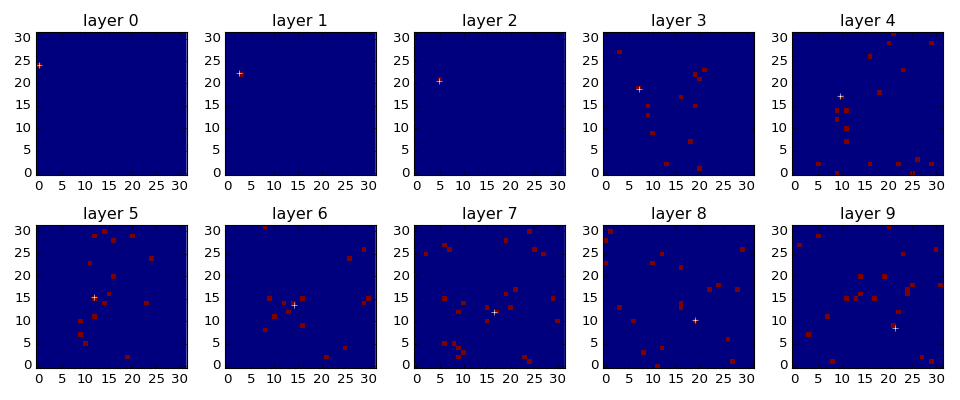

In [5]:
# Visualize one event
disp_idx = 0
# Get the hit coordinates for drawing
idx = np.arange(num_det_layers)
xtruth, ytruth = track_hit_coords(sig_params[disp_idx], idx,
                                  as_type=np.float32)
# Draw it
draw_layers(events[disp_idx], truthx=xtruth, truthy=ytruth)

## Define the model

In [6]:
def build_conv_model(shape, dropout=0.2, l2reg=0.01, pool=(1,2,2)):
    """Build the CNN model"""
    inputs = layers.Input(shape=shape, name='input')

    # Need a 'channel' dimension for 3D convolution, though we have only 1 channel
    hidden = layers.Reshape((1,)+shape, name='reshape_channel')(inputs)

    # 3D convolutional layers
    conv_args = dict(border_mode='same', activation='relu')
    hidden = layers.Convolution3D(8, 3, 3, 3, name='conv3d_1', **conv_args)(hidden)
    hidden = layers.MaxPooling3D(pool_size=(1, 2, 2))(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Convolution3D(16, 3, 3, 3, name='conv3d_2', **conv_args)(hidden)
    hidden = layers.MaxPooling3D(pool_size=(1, 2, 2))(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Convolution3D(32, 3, 3, 3, name='conv3d_3', **conv_args)(hidden)
    hidden = layers.MaxPooling3D(pool_size=(1, 2, 2))(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Convolution3D(64, 3, 3, 3, name='conv3d_4', **conv_args)(hidden)
    hidden = layers.MaxPooling3D(pool_size=(1, 2, 2))(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Convolution3D(96, 3, 3, 3, name='conv3d_5', **conv_args)(hidden)
    #hidden = layers.MaxPooling3D(pool_size=(1, 2, 2))(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Convolution3D(128, 3, 3, 3, name='conv3d_6', **conv_args)(hidden)

    #last_conv = layers.Convolution3D(1, 1, 1, 1, border_mode='same',
    #                                 activation='relu', name='conv3d_6')
    #hidden = last_conv(hidden)
    #hidden = layers.Reshape((hidden_shape[2], np.prod(hidden_shape[3:])),
    #                        name='flatten')(hidden)

    # Permute dimensions to group detector layers:
    # (channels, det_layers, w, w) -> (det_layers, channels, w, w)
    PermuteLayer = layers.Permute((2, 1, 3, 4))
    hidden = PermuteLayer(hidden)

    # Reshape to flatten each detector layer: (det_layers, -1)
    perm_shape = PermuteLayer.output_shape
    flat_shape = (perm_shape[1], np.prod(perm_shape[2:]))
    hidden = layers.Reshape(flat_shape, name='flatten')(hidden)

    # Output softmax
    outputs = layers.TimeDistributed(
        layers.Dense(shape[1]*shape[2], activation='softmax',
                     W_regularizer=l2(l2reg)),
        name='output_softmax')(hidden)

    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='Nadam', metrics=['accuracy'])
    return model

## Training

In [7]:
batch_size = 128
num_epoch = 100
valid_frac = 0.2
l2reg = 0.001

train_input = events
train_target = sig_tracks.reshape(num_event, num_det_layers, -1)

In [8]:
model = build_conv_model(det_shape, l2reg=l2reg)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 10, 32, 32)    0                                            
____________________________________________________________________________________________________
reshape_channel (Reshape)        (None, 1, 10, 32, 32) 0           input[0][0]                      
____________________________________________________________________________________________________
conv3d_1 (Convolution3D)         (None, 8, 10, 32, 32) 224         reshape_channel[0][0]            
____________________________________________________________________________________________________
maxpooling3d_1 (MaxPooling3D)    (None, 8, 10, 16, 16) 0           conv3d_1[0][0]                   
___________________________________________________________________________________________

In [ ]:
history = model.fit(train_input, train_target, batch_size=batch_size,
                    nb_epoch=num_epoch, validation_split=valid_frac)

Train on 81920 samples, validate on 20480 samples
Epoch 1/100
81920/81920 [==============================] - 157s - loss: 4.7105 - acc: 0.0843 - val_loss: 3.0188 - val_acc: 0.2493
Epoch 2/100
81920/81920 [==============================] - 155s - loss: 3.3213 - acc: 0.2092 - val_loss: 2.5410 - val_acc: 0.3524
Epoch 3/100
81920/81920 [==============================] - 155s - loss: 3.0555 - acc: 0.2626 - val_loss: 2.3428 - val_acc: 0.4111
Epoch 4/100
81920/81920 [==============================] - 155s - loss: 2.9125 - acc: 0.2954 - val_loss: 2.2200 - val_acc: 0.4467
Epoch 5/100
81920/81920 [==============================] - 155s - loss: 2.8207 - acc: 0.3161 - val_loss: 2.1301 - val_acc: 0.4714
Epoch 6/100
81920/81920 [==============================] - 155s - loss: 2.7533 - acc: 0.3334 - val_loss: 2.0544 - val_acc: 0.4881
Epoch 7/100
81920/81920 [==============================] - 155s - loss: 2.7005 - acc: 0.3453 - val_loss: 2.0081 - val_acc: 0.4990
Epoch 8/100
81920/81920 [===============

<IPython.core.display.Javascript object>


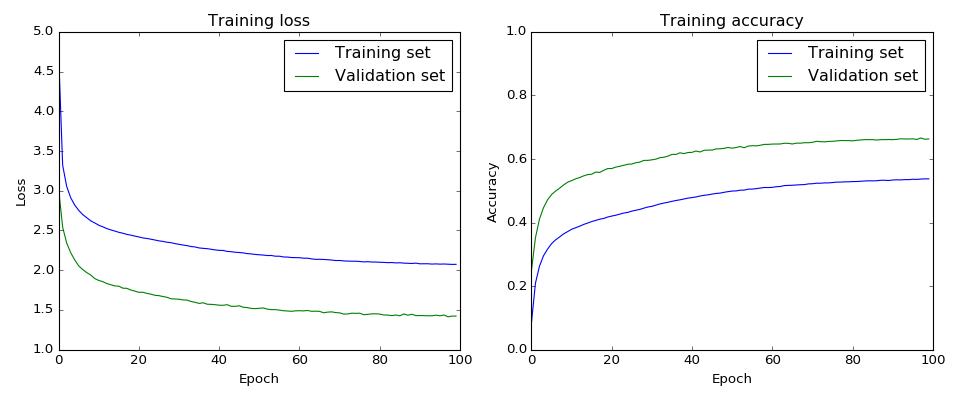

In [11]:
draw_train_history(history)

## Evaluate results

### Training + validation set

In [12]:
# Get the predictions
train_preds = model.predict(train_input, batch_size=batch_size)

In [13]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(train_preds, train_target,
                                   num_seed_layers=num_seed_layers)
# Hit classification accuracy
scores = train_preds * events.reshape(num_event, num_det_layers, -1)
hit_accuracy = calc_hit_accuracy(scores, train_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.5413058035714285
Accuracy of classified hit:  0.8719443359375


In [14]:
# Cleanup
del sig_tracks, events, scores, train_input, train_target, train_preds

### Test set

In [15]:
# Generate a new test dataset
test_num_event = 25600
test_events, test_sigtrks, test_sigparams = generate_data(
    (test_num_event,) + det_shape, num_seed_layers=num_seed_layers,
    avg_bkg_tracks=avg_bkg_tracks, noise_prob=noise_prob)
test_target = test_sigtrks.reshape(test_num_event, num_det_layers, -1)

Sizes of arrays
  events:     1048.58 MB
  sig_tracks: 1048.58 MB
  bkg_tracks: 1048.58 MB
  noise:      262.144 MB
  sig_params: 0.8192 MB


In [16]:
# Run the model on the test set
test_preds = model.predict(test_events, batch_size=batch_size)

Input data example event:


<IPython.core.display.Javascript object>


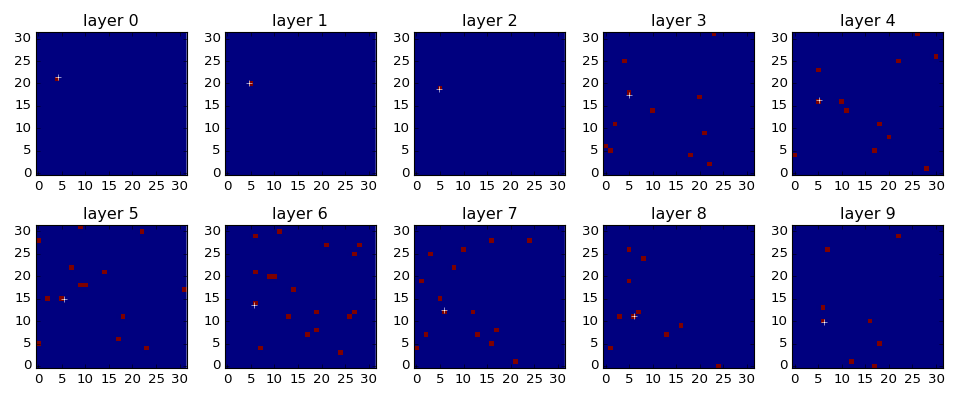

Model prediction:


<IPython.core.display.Javascript object>


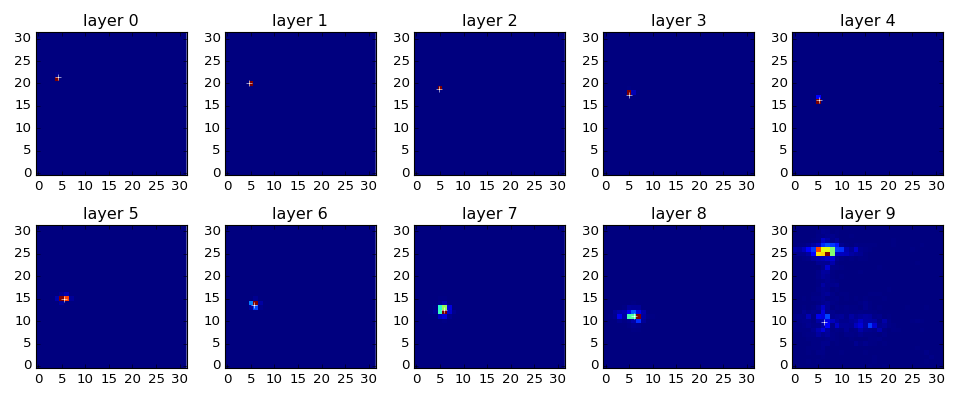

Projected input data:


<IPython.core.display.Javascript object>


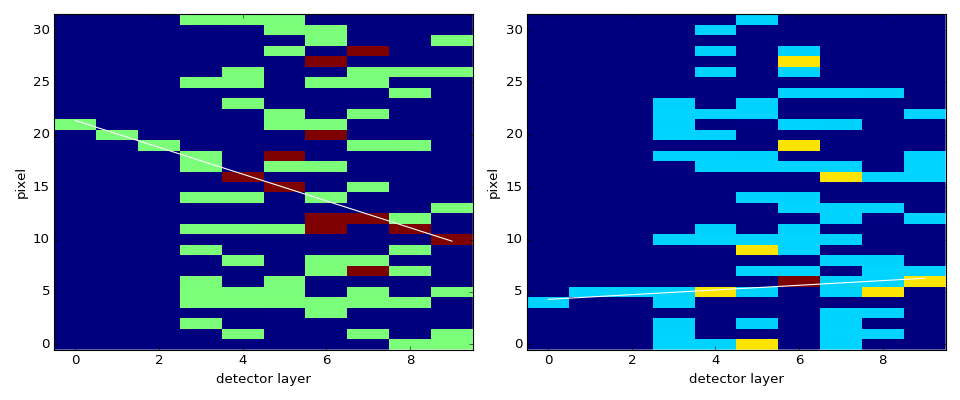

Projected model prediction:


<IPython.core.display.Javascript object>


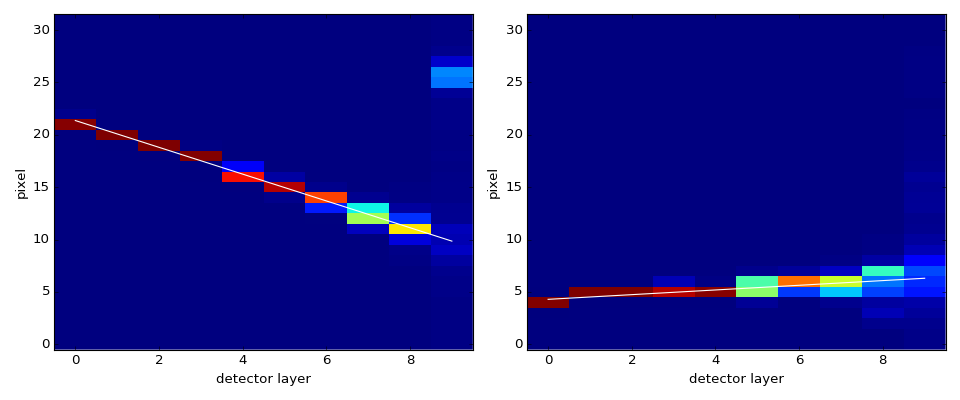

In [17]:
# Select an event to visualize
disp_idx = 1

# Get the hit coordinates for drawing
idx = np.arange(num_det_layers)
xtruth, ytruth = track_hit_coords(test_sigparams[disp_idx],
                                  idx, as_type=np.float32)

# Draw the layers
print('Input data example event:')
draw_layers(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Model prediction:')
draw_layers(test_preds[disp_idx].reshape(det_shape),
            truthx=xtruth, truthy=ytruth)
print('Projected input data:')
draw_projections(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Projected model prediction:')
draw_projections(test_preds[disp_idx].reshape(det_shape),
                 truthx=xtruth, truthy=ytruth)

In [18]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test_preds, test_target,
                                   num_seed_layers=num_seed_layers)
# Hit classification accuracy
test_scores = test_preds * test_events.reshape(test_num_event, num_det_layers, -1)
hit_accuracy = calc_hit_accuracy(test_scores, test_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.5203236607142857
Accuracy of classified hit:  0.86033203125
